<a href="https://colab.research.google.com/github/betr0dalf/PZMS/blob/main/PZMS_NovikovDV_prac3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прикладные задачи математической статистики
# Практическая работа № 3
# Выполнил студент группы ИНБО-05-22
# Новиков Денис Владиславович

In [ ]:
import pandas as pd
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import math
from scipy.stats import laplace, chi2
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statistics import stdev
from scipy.stats import norm, expon, chi2_contingency, chi2
import seaborn as sns
import statistics
from matplotlib.patches import Polygon
from sklearn.preprocessing import MinMaxScaler;

In [ ]:
#Функция расчета интервалов
def create_bins(data):

    data = data['number'].values

    # Размер выборки
    n = len(data)

    # Число групп по правилу Стёрджесса
    m = round(1 + 3.322 * np.log10(n))

    # Минимальное и максимальное значение
    min_height = data.min()
    max_height = data.max()

    # Подсчет шага интервала
    interval_size = (max_height - min_height) / m

    # Определение границы интервалов
    start = min_height - 0.01
    end = max_height + 0.01

    # Подсчет границы интервалов
    intervals = np.arange(start, end, interval_size)

    return intervals

In [ ]:
# Критерий Пирсона для показательного распределения

def pirson_pokaz(data, bins):
    observed_data = data['number'].values

    # Оценка параметра λ (лямбда) показательного распределения
    lambda_param = 1 / np.mean(observed_data)

    # Подсчет наблюдаемых частот
    observed_frequencies, _ = np.histogram(observed_data, bins=bins)

    # Вычисление ожидаемых частот на основе показательного распределения
    expected_frequencies = []
    for i in range(len(bins) - 1):
        expected_count = len(observed_data) * ((-( math.exp(bins[i+1]*lambda_param*(-1))) + ( math.exp(bins[i]*lambda_param*(-1)))))
        expected_frequencies.append(expected_count)

    expected_frequencies = np.array(expected_frequencies)

    # Вычисление статистики хи-квадрат
    chi_square_statistic = np.sum((observed_frequencies - expected_frequencies) ** 2 / expected_frequencies)

    # Степени свободы
    degrees_of_freedom = len(observed_data) - 1 - 1  # -1 за параметр λ

    # Уровень значимости
    alpha = 0.05

    # Критическое значение хи-квадрат
    critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

    return chi_square_statistic, critical_value

In [ ]:
# Критерий Пирсона для нормального распределения

def pirson_norm(data, bins):
    obs_data = data['number'].values

    # Подсчет наблюдаемых частот (абсолютная частота)
    observed_frequencies, _ = np.histogram(obs_data, bins=bins)

    mean_num = np.mean(obs_data)
    std_num= np.std(obs_data)

    # Вычисление ожидаемых частот (относительные частоты)
    expected_frequencies = []
    for i in range(len(bins) - 1):
        expected_count = len(obs_data) * (laplace.cdf((bins[i+1]-mean_num)/std_num)-laplace.cdf((bins[i]-mean_num)/std_num))
        expected_frequencies.append(expected_count)

    expected_frequencies = np.array(expected_frequencies)

    # Вычисление статистики хи-квадрат
    chi_square_statistic = np.sum((observed_frequencies - expected_frequencies) ** 2 / expected_frequencies)

    # Степени свободы
    degrees_of_freedom = len(bins) - 2 - 1

    # Уровень значимости
    alpha = 0.05

    # Критическое значение хи-квадрат
    critical_value = chi2.ppf(1 - 0.05, degrees_of_freedom)

    return chi_square_statistic, critical_value

In [ ]:
# Анаморфоза нормального распределения

def anamorphosis_norm(data, intervals, wi):
    dlt = [i for i, num in enumerate(wi) if num == 0]
    intervals = np.delete(intervals, dlt, axis=0)
    wi = np.delete(wi, dlt)

    y = np.log(wi)
    # Вычисление центров интервалов
    centres = []
    for i in range(len(intervals)):
        # Проверка, чтобы не выйти за пределы массива
        if i < len(intervals) - 1:
            centre = (intervals[i] + intervals[i + 1]) / 2
            centres.append(centre)

    centres = np.array(centres)

    mean = np.mean(data)
    mae = (centres - mean) ** 2

    X_new = mae.reshape(-1, 1)

    model = LinearRegression()
    model.fit(X_new, y)
    W = np.array([model.intercept_, model.coef_[0]])

    k = W[1]
    std = np.sqrt(-1 / (2 * k))
    print("Стандартное отклонение (параметр std):", std)

    fig, ax = plt.subplots()
    plt.figure(figsize=(5, 5))
    ax.scatter(x=mae, y=y)
    ax.plot(mae, model.predict(X_new), color='r')
    ax.set_title("Анаморфоза нормального распределения")
    ax.set_xlabel("(x-mean)^2")
    ax.set_ylabel("ln(w)")
    ax.grid()
    plt.show()

    return std, r2_score(y, model.predict(X_new))

In [ ]:
# Анаморфоза показательного распределениz

def anamorphosis_exp(data, intervals, wi):
    dlt = [i for i, num in enumerate(wi) if num == 0]
    intervals = np.delete(intervals, dlt, axis=0)
    wi = np.delete(wi, dlt)

    y = np.log(wi)
    centres = []
    for i in range(len(intervals)):
        # Проверка, чтобы не выйти за пределы массива
        if i < len(intervals) - 1:
            centre = (intervals[i] + intervals[i + 1]) / 2
            centres.append(centre)

    centres = np.array(centres)

    X_new = centres.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X_new, y)
    W = np.array([model.intercept_, model.coef_[0]])

    k = W[1]
    lmbd = -k
    print('Параметр lambda: ', lmbd)

    fig, ax = plt.subplots()
    plt.figure(figsize=(5, 5))
    ax.scatter(x=centres, y=y)
    ax.plot(centres, model.predict(X_new), color='r')
    ax.set_title("Анаморфоза показательного распределения")
    ax.set_xlabel("x")
    ax.set_ylabel("ln(w)")
    ax.grid()
    plt.show()

    return lmbd, r2_score(y, model.predict(X_new))

In [ ]:
# Вывод для первого задания
def task_1(dat):
    # Определяем интервалы

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(dat), columns = dat.columns)


    bins = create_bins(data)

    # Гистограмма относительных частот

    plt.hist(data, bins=bins, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Гистограмма распределения относительных частот')
    plt.xlabel('Данные')
    plt.ylabel('Относительная частота')
    plt.show()

    # Проверка на нормального распределение
    chi_square_statistic, critical_value = pirson_norm(data, bins)

    print(f"Статистика хи-квадрат: {(chi_square_statistic)}")
    print(f"Критическое значение хи-квадрат для уровня значимости : {critical_value}")

    # Проверка гипотезы
    if (chi_square_statistic) > critical_value:
        print("Гипотеза о нормальном распределении отвергается.")
    else:
        print("Гипотеза о нормальном распределении не отвергается.")

    # Проверка на показательно распределение
    chi_square_statistic, critical_value = pirson_pokaz(data, bins)

    print(f"Статистика хи-квадрат: {(chi_square_statistic)}")
    print(f"Критическое значение хи-квадрат для уровня значимости : {critical_value}")

    # Проверка гипотезы
    if (chi_square_statistic) > critical_value:
        print("Гипотеза о показательном распределении отвергается.")
    else:
        print("Гипотеза о показательном распределении не отвергается.")

In [ ]:
# Вывод для второго задания
def task_2(data):
    # Определяем интервалы
    bins = create_bins(data)

    observed_data = data['number'].values

    # Распределение по интервалам и подсчет частот
    absolute_count = pd.cut(observed_data, bins=bins, right=False).value_counts().sort_index()

    # Относительные частоты
    relative_frequencies = absolute_count / len(data)


    std_norm, r2_norm = anamorphosis_norm(observed_data, bins, relative_frequencies)
    if r2_norm > 0.8:
      print("Распределение соответствует нормальному", round(r2_norm, 3), "> 0.8")
    else:
      print("Распределение не соответствует нормальному", round(r2_norm, 3), "≤ 0.8")

    std_pok, r2_pok = anamorphosis_exp(observed_data, bins, relative_frequencies)
    if r2_pok>0.8:
      print("Распределение соответствует показательному", round(r2_pok, 3), "> 0.8")
    else:
      print("Распределение не соответствует показательному", round(r2_pok, 3), "≤ 0.8")

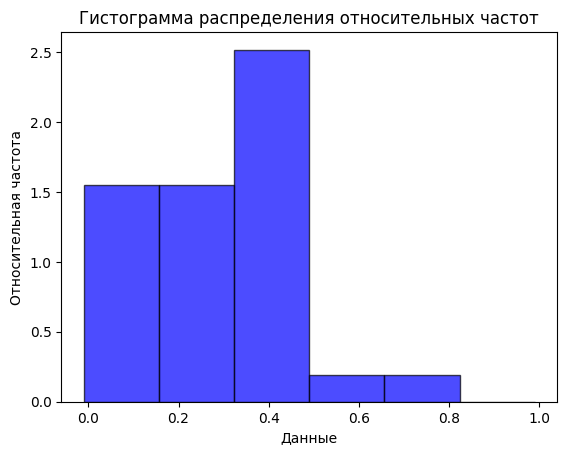

Статистика хи-квадрат: 8.682946651063592
Критическое значение хи-квадрат для уровня значимости : 9.487729036781154
Гипотеза о нормальном распределении не отвергается.
Статистика хи-квадрат: 19.463229129634943
Критическое значение хи-квадрат для уровня значимости : 43.77297182574219
Гипотеза о показательном распределении не отвергается.


In [ ]:
data_1 = pd.read_csv('1.txt', sep='\t', header=None, names=['number'])
task_1(data_1)

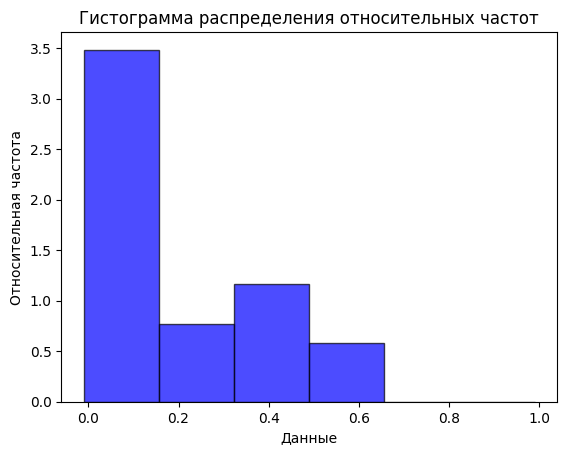

Статистика хи-квадрат: 29.45411653661152
Критическое значение хи-квадрат для уровня значимости : 9.487729036781154
Гипотеза о нормальном распределении отвергается.
Статистика хи-квадрат: 5.196431307758192
Критическое значение хи-квадрат для уровня значимости : 43.77297182574219
Гипотеза о показательном распределении не отвергается.


In [ ]:
data_3 = pd.read_csv('3.txt', sep='\t', header=None, names=['number'])
task_1(data_3)

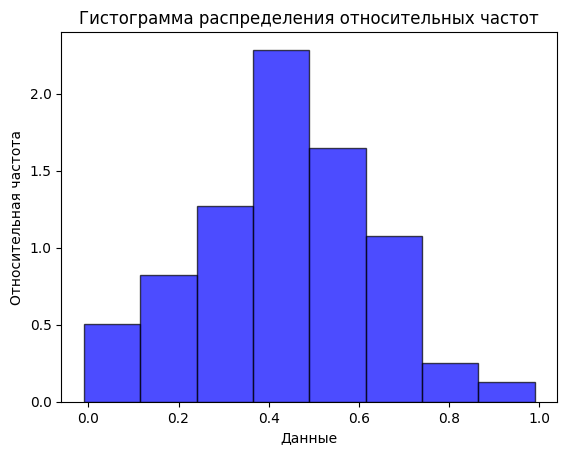

Статистика хи-квадрат: 5.124066610175468
Критическое значение хи-квадрат для уровня значимости : 12.591587243743977
Гипотеза о нормальном распределении не отвергается.
Статистика хи-квадрат: 94.8580334018982
Критическое значение хи-квадрат для уровня значимости : 153.1979027439562
Гипотеза о показательном распределении не отвергается.


In [ ]:
data_4 = pd.read_csv('4.txt', sep='\t', header=None, names=['number'])
task_1(data_4)

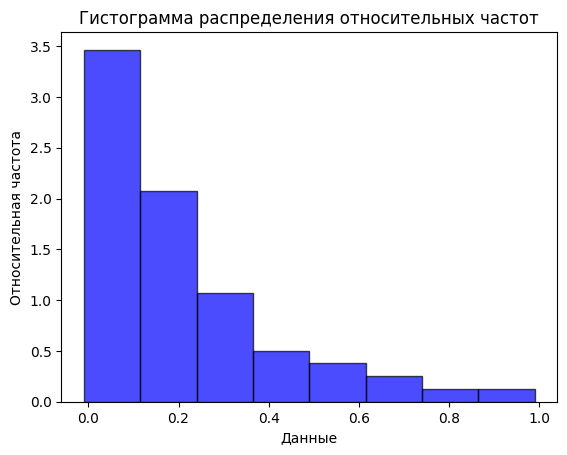

Статистика хи-квадрат: 84.18580363813169
Критическое значение хи-квадрат для уровня значимости : 12.591587243743977
Гипотеза о нормальном распределении отвергается.
Статистика хи-квадрат: 2.212015881914015
Критическое значение хи-квадрат для уровня значимости : 153.1979027439562
Гипотеза о показательном распределении не отвергается.


In [ ]:
data_6 = pd.read_csv('6.txt', sep='\t', header=None, names=['number'])
task_1(data_6)

Стандартное отклонение (параметр std): 4.159552260657853


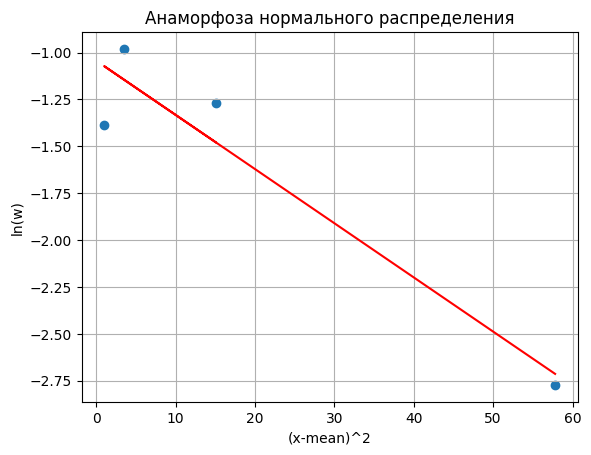

<Figure size 500x500 with 0 Axes>

Распределение соответствует нормальному 0.91 > 0.8
Параметр lambda:  0.1283392471193147


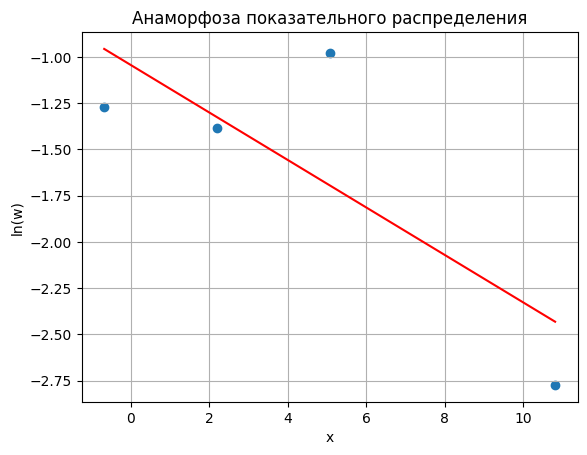

<Figure size 500x500 with 0 Axes>

Распределение не соответствует показательному 0.621 ≤ 0.8


In [ ]:
task_2(data_1)

Стандартное отклонение (параметр std): 6.647103783238564


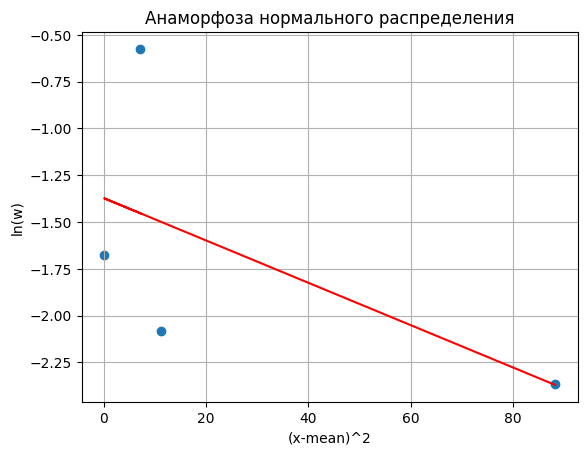

<Figure size 500x500 with 0 Axes>

Распределение не соответствует нормальному 0.353 ≤ 0.8
Параметр lambda:  0.13569875059544834


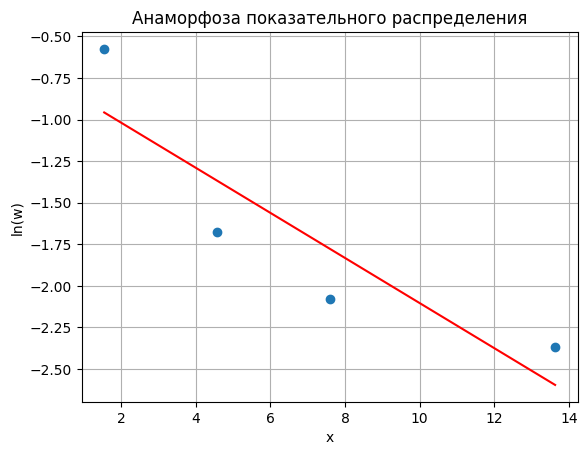

<Figure size 500x500 with 0 Axes>

Распределение не соответствует показательному 0.793 ≤ 0.8


In [ ]:
task_2(data_3)

Стандартное отклонение (параметр std): 2.473783743853524


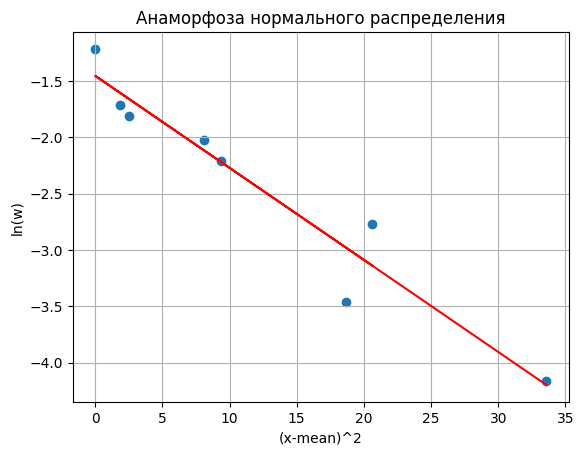

<Figure size 500x500 with 0 Axes>

Распределение соответствует нормальному 0.93 > 0.8
Параметр lambda:  0.13788752922690084


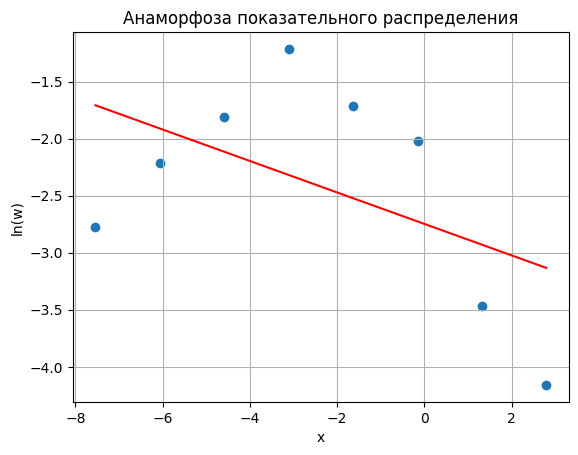

<Figure size 500x500 with 0 Axes>

Распределение не соответствует показательному 0.257 ≤ 0.8


In [ ]:
task_2(data_4)

Стандартное отклонение (параметр std): 3.0899362413521914


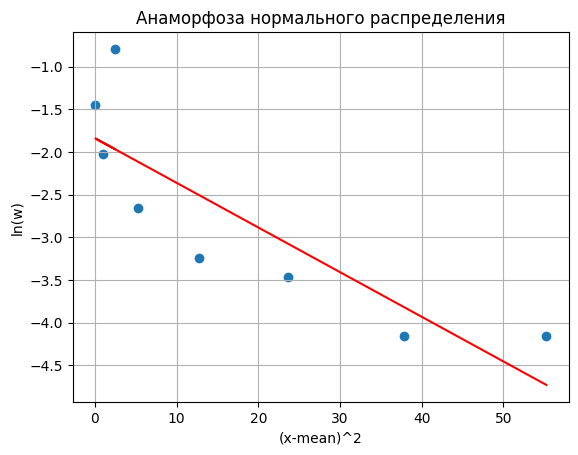

<Figure size 500x500 with 0 Axes>

Распределение не соответствует нормальному 0.724 ≤ 0.8
Параметр lambda:  0.38929640082346917


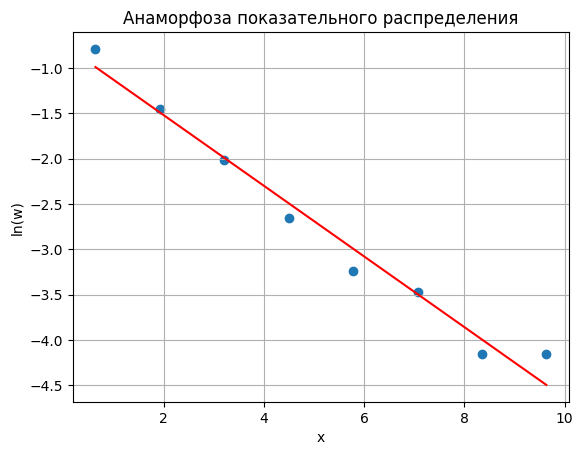

<Figure size 500x500 with 0 Axes>

Распределение соответствует показательному 0.975 > 0.8


In [ ]:
task_2(data_6)